In [1]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time
import math

In [2]:
%run ../../shared_functions.py
%run ../../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [3]:
DIR_INPUT = '../../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 594 ms
Wall time: 924 ms
919767 transactions loaded, containing 8195 fraudulent transactions


### Default

In [4]:
BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5

In [5]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cuda


In [6]:
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])

#### Fit 1 cycle

In [7]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'train test split',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=16,
    num_workers=0,
    seq_len=SEQ_LEN,
    cat_szs=0,
    n_cont=0,
    n_latents=512,
    d_latent=128,
    d_context=None,
    n_layers=6,
    self_per_cross_attn=1,
    share_weights=True,
    cross_n_heads=1,
    self_n_heads=8,
    d_head=None,
    attn_dropout=0,
    fc_dropout=0,
    concat_pool=False,
    optimizer='adam',
    early_stopping=True,
    early_stopping_patience=2,
    max_epochs=100,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['tsperceiver', 'transformer', 'tsai', 'imbalance-not-considered'])
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin


In [8]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.TSPerceiver(
    c_in=dls.vars, 
    c_out=dls.c,
    seq_len=SEQ_LEN,
    cat_szs=config.cat_szs,
    n_cont=config.n_cont,
    n_latents=config.n_latents,
    d_latent=config.d_latent,
    d_context=config.d_context,
    n_layers=config.n_layers,
    self_per_cross_attn=config.self_per_cross_attn,
    share_weights=config.share_weights,
    cross_n_heads=config.cross_n_heads,
    self_n_heads=config.self_n_heads,
    d_head=config.d_head,
    attn_dropout=config.attn_dropout,
    fc_dropout=config.fc_dropout,
    concat_pool=config.concat_pool,
    )

In [9]:
criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='TSPerceiver',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        EarlyStoppingCallback(
            patience=config.early_stopping_patience
        ),
        SaveModelCallback(
            fname='tsperceiver_fit_one_cycle'
        )])

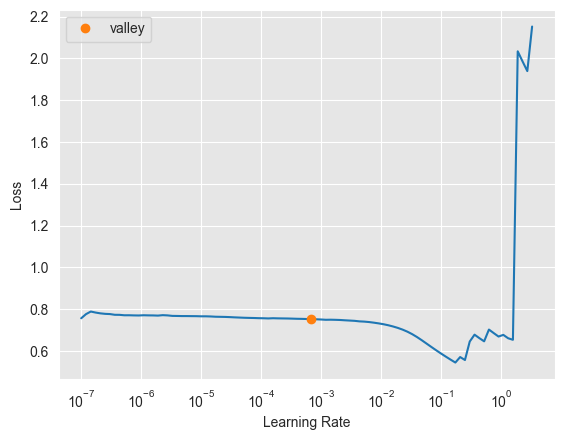

In [10]:
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

In [11]:
start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.184693,0.170461,1:21:54
1,0.030545,0.034050,1:20:29
2,0.026480,0.027176,1:20:30
3,0.034290,0.028336,1:20:28
4,0.041763,0.027889,1:20:28


Better model found at epoch 0 with valid_loss value: 0.17046098411083221.
Better model found at epoch 1 with valid_loss value: 0.034050438553094864.
Better model found at epoch 2 with valid_loss value: 0.027176136150956154.
No improvement since epoch 2: early stopping


In [12]:
start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

,AUC ROC,Average precision,F1 score,Card Precision@100
0,0.888,0.283,0.204,0.283


In [13]:
wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
mom_0,███████████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
raw_loss,█▇▇▆▅▅▄▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
